# Setup

In [ ]:
# # don't do this; transformerlens or saelens incompat w/ latest numpy?

# %%capture
# !pip install --upgrade numpy pandas
# !pip install umap-learn matplotlib

In [ ]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Standard imports
import os
import torch
from tqdm import tqdm

torch.set_grad_enabled(False);

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 941.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.0/920.0 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


# Loading a pretrained Sparse Autoencoder

Below we load a Transformerlens model, a pretrained SAE and a dataset from huggingface.

In [4]:
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE

model = HookedTransformer.from_pretrained("gpt2-small", device = device)

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release = "gpt2-small-res-jb", # see other options in sae_lens/pretrained_saes.yaml
    sae_id = "blocks.8.hook_resid_pre", # won't always be a hook point
    device = device
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


blocks.8.hook_resid_pre/cfg.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/98.4k [00:00<?, ?B/s]

In [5]:
sae.W_enc.shape

torch.Size([768, 24576])

# get weights

In [ ]:
weight_matrix_np = sae.W_enc.cpu()

In [ ]:
import pickle
with open('weight_matrix.pkl', 'wb') as f:
    pickle.dump(weight_matrix_np, f)

In [ ]:
# from google.colab import files
# files.download('weight_matrix.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# if files doesn't work:

from google.colab import drive
drive.mount('/content/drive')

# Move the file to your Google Drive
!cp weight_matrix.pkl /content/drive/MyDrive/

Mounted at /content/drive


# get activations

In [6]:
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset(
    path = "NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset= dataset,# type: ignore
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (229134 > 1024). Running this sequence through the model will result in indexing errors


In [7]:
sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

with torch.no_grad():
    # activation store can give us tokens.
    batch_tokens = token_dataset[:32]["tokens"]
    _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

    # Use the SAE
    feature_acts = sae.encode(cache[sae.cfg.hook_name])
    sae_out = sae.decode(feature_acts)

    # save some room
    del cache

    # ignore the bos token, get the number of features that activated in each token, averaged accross batch and position
    # l0 = (feature_acts[:, 1:] > 0).float().sum(-1).detach()
    # print("average l0", l0.mean().item())
    # px.histogram(l0.flatten().cpu().numpy()).show()

In [10]:
feature_acts.shape

torch.Size([32, 128, 24576])

In [8]:
import pickle
with open('feature_acts.pkl', 'wb') as f:
    pickle.dump(feature_acts, f)

In [12]:
# this takes a while!

from google.colab import files
files.download('feature_acts.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# if files doesn't work: (this is quicker)

from google.colab import drive
drive.mount('/content/drive')

# Move the file to your Google Drive
!cp feature_acts.pkl /content/drive/MyDrive/

Mounted at /content/drive


# plot weights pca

In [ ]:
# this also takes a long time

import numpy as np
import pandas as pd

def pca_pandas(data, n_components=2):
    df = pd.DataFrame(data)
    data_mean = df.mean()
    centered_data = df - data_mean

    # Compute covariance matrix
    cov_matrix = centered_data.cov()

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    sorted_idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_idx]

    # Select the top n_components eigenvectors
    top_eigenvectors = sorted_eigenvectors[:, :n_components]

    # Project the data onto the top n_components eigenvectors
    reduced_data = np.dot(centered_data, top_eigenvectors)

    return reduced_data

# Example usage
weight_matrix_pca = pca_pandas(weight_matrix_np)

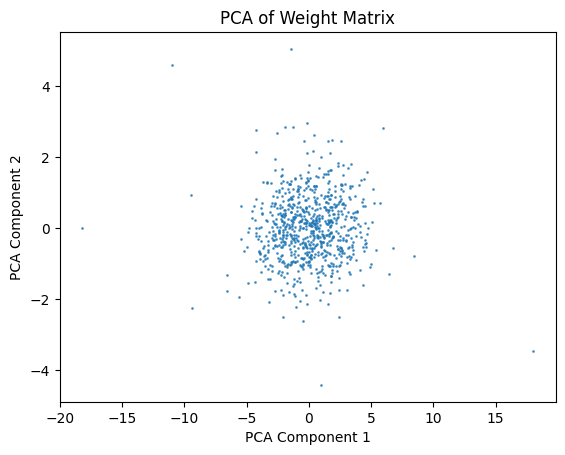

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(weight_matrix_pca[:, 0], weight_matrix_pca[:, 1], s=1, alpha=0.7)
plt.title('PCA of Weight Matrix')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# plot decoder weights

# plot activations

In [17]:
reshaped_activations = feature_acts.reshape(32 * 128, 24576)

acts_matrix_pca = pca_pandas(reshaped_activations.cpu())

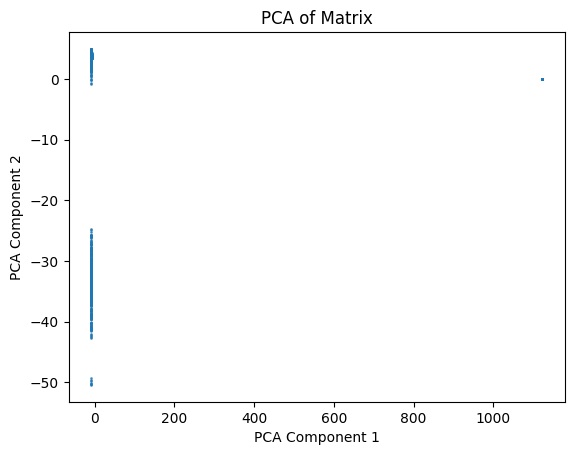

In [18]:
import matplotlib.pyplot as plt

plt.scatter(acts_matrix_pca[:, 0], acts_matrix_pca[:, 1], s=1, alpha=0.7)
plt.title('PCA of Matrix')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()